In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
sys.path.append('../utils')
import operator_calculations as op_calc
import stats
from sklearn.linear_model import LinearRegression
import delay_embedding as embed
import clustering_methods as cl
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]
plt.rc('text', usetex=True)
plt.rc('font',size=14)

In [2]:
def Lorenz(state,t,sigma,rho,beta):
    # unpack the state vector
    x,y,z = state
    # compute state derivatives
    xd = sigma * (y-x)
    yd = (rho-z)*x - y
    zd = x*y - beta*z
    # return the state derivatives
    return [xd, yd, zd]
dt = 0.02
frameRate=1/dt
T = 2000
discard_T = 100
T_total = T+discard_T
state0 = np.array([-8, -8, 27])
t = np.linspace(0, T_total, int(T_total*frameRate))
sigma,rho,beta=10,28,8/3
tseries=np.array(odeint(Lorenz,state0,t,args=(sigma,rho,beta)),dtype=np.float64)[int(discard_T/dt):]

In [3]:
tseries.shape

(100000, 3)

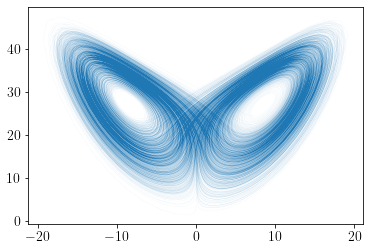

In [6]:
plt.plot(tseries[:,0],tseries[:,2],lw=.02)
plt.show()

# Compute predictability as a function of delay

In [17]:
X = tseries[:,0].reshape((tseries.shape[0],1)) #take x variable only

In [18]:
#to get error estimates in the manuscript we split the trajectory into non-overlapping segments

n_seed_range=np.array(np.logspace(2,3,4),dtype=int) #number of partitions to examine
range_Ks =  np.arange(2,16,2,dtype=int) #range of delays to study
h_K=np.zeros((len(range_Ks),len(n_seed_range)))
for k,K in enumerate(range_Ks):
    traj_matrix = embed.trajectory_matrix(ma.masked_invalid(X),K=K-1)
    for ks,n_seeds in enumerate(n_seed_range):
        labels=cl.kmeans_knn_partition(traj_matrix,n_seeds)
        h = op_calc.get_entropy(labels)
        h_K[k,ks]=h
        print('Computed for {} delays and {} seeds.'.format(K,n_seeds))

Computed for 2 delays and 100 seeds.
Computed for 2 delays and 215 seeds.
Computed for 2 delays and 464 seeds.
Computed for 2 delays and 1000 seeds.
Computed for 4 delays and 100 seeds.
Computed for 4 delays and 215 seeds.
Computed for 4 delays and 464 seeds.
Computed for 4 delays and 1000 seeds.
Computed for 6 delays and 100 seeds.
Computed for 6 delays and 215 seeds.
Computed for 6 delays and 464 seeds.
Computed for 6 delays and 1000 seeds.
Computed for 8 delays and 100 seeds.
Computed for 8 delays and 215 seeds.
Computed for 8 delays and 464 seeds.
Computed for 8 delays and 1000 seeds.
Computed for 10 delays and 100 seeds.
Computed for 10 delays and 215 seeds.
Computed for 10 delays and 464 seeds.
Computed for 10 delays and 1000 seeds.
Computed for 12 delays and 100 seeds.
Computed for 12 delays and 215 seeds.
Computed for 12 delays and 464 seeds.
Computed for 12 delays and 1000 seeds.
Computed for 14 delays and 100 seeds.
Computed for 14 delays and 215 seeds.
Computed for 14 delays

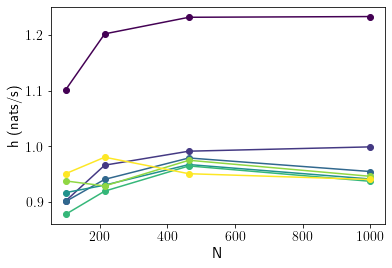

In [19]:
colors_K = plt.cm.viridis(np.linspace(0,1,len(range_Ks)))
for k,K in enumerate(range_Ks):
    plt.plot(n_seed_range,h_K[k],c=colors_K[k],marker='o')
plt.xlabel('N',fontsize=15)
plt.ylabel('h (nats/s)',fontsize=15)
plt.show()

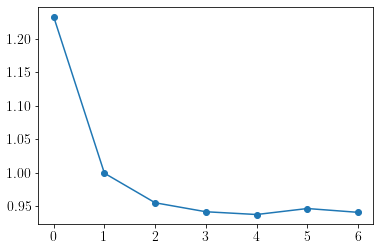

In [20]:
plt.plot(h_K[:,3],marker='o')
plt.show()

In [21]:
K_star=12
traj_matrix = embed.trajectory_matrix(X,K=K_star-1)

# Estimate implied time scales of the reversibilized operator

In [22]:
#to get error estimates in the manuscript we split the trajectory into non-overlapping segments

n_seeds = 1000
n_modes=10

labels = ma.array(cl.kmeans_knn_partition(traj_matrix,n_seeds),dtype=int)

delay_range = np.arange(1,20,1)
n_modes=5
ts_traj = np.zeros((len(delay_range),n_modes))
for kd,delay in enumerate(delay_range):
    P = op_calc.transition_matrix(labels,delay)
    R = op_calc.get_reversible_transition_matrix(P)
    ts_traj[kd,:] = op_calc.compute_tscales(R,delay,dt,k=n_modes+1)
    print(delay)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


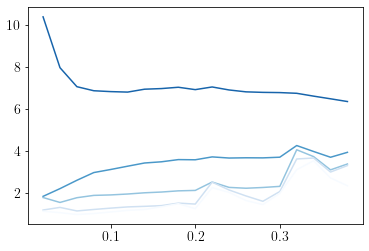

In [23]:
colors_modes = plt.cm.Blues_r(np.linspace(0.2,1,n_modes))
for km in range(n_modes):
    plt.plot(delay_range*dt,ts_traj[:,km],c=colors_modes[km])
plt.show()

In [24]:
delay = 10
print(delay*dt)
P = op_calc.transition_matrix(labels,delay)
R = op_calc.get_reversible_transition_matrix(P)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=3)
print(eigvals)

0.2
[1.        +0.j 0.9715312 +0.j 0.94547695+0.j]


In [25]:
u,s,v = np.linalg.svd(traj_matrix,full_matrices=False)

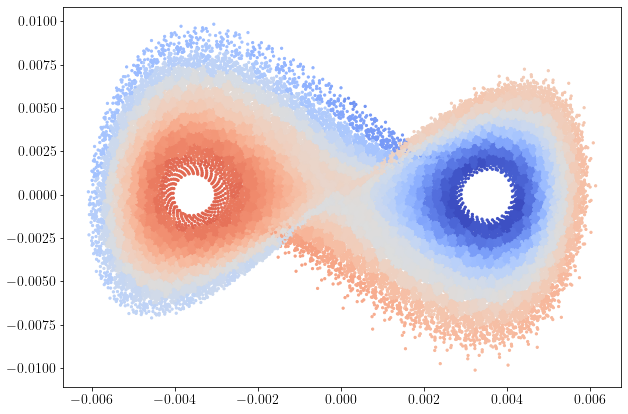

In [26]:
phi2=eigvecs[labels,1].real
plt.figure(figsize=(10,7))
color_abs = np.max(np.abs(phi2))
plt.scatter(u[:,0],u[:,1],c=phi2,cmap='coolwarm',s=5,vmin=-color_abs,vmax=color_abs)
plt.show()